# Fluid-Solid boundary 

This example demonstrates how to run a fluid-solid simulation and define
sources and receivers from Python instead of using `Par_file` and
`specfem_config.yml`, `sources.yml`, and `STATIONS` files.
This example is contributed by Sirawich Pipatprathanporn and is part of the
publication [Pipatprathanporn et al.
(2024)](https://doi.org/10.1093/gji/ggae238)

## Creating the mesh

We need a mesh to run the simulation. This step still requires a ``Par_file``
and a call to ``xmeshfem2D``. For the explanation of the ``Par_file``, please
refer to the [SPECFEM++
documentation](https://specfem2d-kokkos.readthedocs.io/en/latest/meshfem2d/index.html).

In [10]:
from subprocess import call
from os import makedirs

from specfempp import Config, execute

# Create the output directory for the database files.
makedirs("OUTPUT_FILES/results", exist_ok=True)
call("xmeshfem2D -p Par_file", shell=True)



 **********************************************
 *** Specfem 2-D Mesher - serial version    ***
 **********************************************

 Running Git version of the code corresponding to f8c66778e3bcff99be726113a1aca338255ed87e
 dating 2023-03-21 19:54:51 +0100

 Reading the parameter file...

 Title of the simulation: fluid-solid-bathymetry

 Receiver lines:
   Nb of line sets =            2

 Materials:
   Nb of solid, fluid or porous materials =            2

 --------
 Material #           1  isotropic
 rho,cp,cs   =    2500.0000000000000        3400.0000000000000        1963.0000000000000     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is solid
 --------
 Material #           2  isotropic
 rho,cp,cs   =    1020.0000000000000        1500.0000000000000        0.0000000000000000     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is fluid
 --------


 Mesh from internal meshing:

 Reading interface data from f

0

The output should be quite long, but end with something like:
```bash
This will be a serial simulation
```
Now, that we have a mesh, we can set up the simulation. This is entirely done
from python. We start by importing functions to load a parameter file
get and set parameters, and execute the simulation.
So that we don't start completely from scratch, let's load a parameter file
that is already set up for a fluid-solid simulation.

In [11]:
config = Config({
    "databases": {
        "mesh-database": "OUTPUT_FILES/database.bin"
    },
    "header": {
        "description": "Material systems : Elastic domain (1), Acoustic domain (1)\nInterfaces : Acoustic-elastic interface (1) (orientation horizontal with acoustic domain on top)\nSources : Moment-tensor (234)\nBoundary conditions : Neumann BCs on all edges\n",
        "title": "fluid-solid-bathymetry"
    },
    "receivers": {
        "angle": 0.0,
        "nstep_between_samples": 10,
        "seismogram-type": [
            "pressure"
        ],
        "stations": "OUTPUT_FILES/STATIONS"
    },
    "run-setup": {
        "number-of-processors": 1,
        "number-of-runs": 1
    },
    "simulation-setup": {
        "quadrature": {
            "quadrature-type": "GLL4"
        },
        "simulation-mode": {
            "forward": {
                "writer": {
                    "display": {
                        "directory": "OUTPUT_FILES/results",
                        "field": "displacement",
                        "format": "PNG",
                        "simulation-field": "forward",
                        "time-interval": 100
                    },
                    "seismogram": {
                        "directory": "OUTPUT_FILES/results",
                        "format": "ascii"
                    }
                }
            }
        },
        "solver": {
            "time-marching": {
                "time-scheme": {
                    "dt": 0.001,
                    "nstep": 32500,
                    "type": "Newmark"
                },
                "type-of-simulation": "forward"
            }
        }
    },
    "sources": "line_sources.yaml"
})

The parameters can be inspected using the `get_par` function.

In [12]:
print(config.get_par("header.description"))
print("DT:", config.get_par("simulation-setup.solver.time-marching.time-scheme.dt"))
print("NT:", config.get_par("simulation-setup.solver.time-marching.time-scheme.nstep"))

Material systems : Elastic domain (1), Acoustic domain (1)
Interfaces : Acoustic-elastic interface (1) (orientation horizontal with acoustic domain on top)
Sources : Moment-tensor (234)
Boundary conditions : Neumann BCs on all edges

DT: 0.001
NT: 32500


Let's set the number of time steps to 5000 and the time step size to 0.002.

In [13]:
dt = 0.002
nstep = 5000
config.set_par('simulation-setup.solver.time-marching.time-scheme.dt', dt)
config.set_par('simulation-setup.solver.time-marching.time-scheme.nstep', nstep)

## Defining a source

We can define the sources using a file, which is the default behaviour for
``specfem2d``. The file is called `sources.yml` and is loaded during execution
via

In [14]:
print(config.get_par("sources"))

line_sources.yaml


We can update the sources programmatically by setting the the ``source-file``
parameter to a dictionary value. For this example, we want to define a line
source on the left boundary and bottom of the mesh that immitates a plane wave impinging on the domain from the left at
an angle of 30 degrees. The source is located at the top of the domain

In [15]:
# Define the number of sources in x in z direction
number_of_sources_x = 197
number_of_sources_z = 37

# Define the source dictionary
source_dict = dict()
source_dict["number-of-sources"] = number_of_sources_x + number_of_sources_z
source_list = list()

# Append sources in x direction
for i in range(number_of_sources_x):
    moment_tensor = {"moment-tensor": dict()}
    moment_tensor["moment-tensor"]["x"] = 200.0 + i * 100.0
    moment_tensor["moment-tensor"]["z"] = 720.0
    moment_tensor["moment-tensor"]["Mxx"] = 1.0
    moment_tensor["moment-tensor"]["Mzz"] = 1.0
    moment_tensor["moment-tensor"]["Mxz"] = 0.0
    moment_tensor["moment-tensor"]["angle"] = 0.0
    moment_tensor["moment-tensor"]["Ricker"] = dict()
    moment_tensor["moment-tensor"]["Ricker"]["factor"] = 9.836e-10
    moment_tensor["moment-tensor"]["Ricker"]["tshift"] = 5.309e-03 * i
    moment_tensor["moment-tensor"]["Ricker"]["f0"] = 1.0
    source_list.append(moment_tensor)

# Append sources in z direction
for i in range(number_of_sources_z):
    moment_tensor = {"moment-tensor": dict()}
    moment_tensor["moment-tensor"]["x"] = 200.0
    moment_tensor["moment-tensor"]["z"] = 820.0 + i * 100.0
    moment_tensor["moment-tensor"]["Mxx"] = 1.0
    moment_tensor["moment-tensor"]["Mzz"] = 1.0
    moment_tensor["moment-tensor"]["Mxz"] = 0.0
    moment_tensor["moment-tensor"]["angle"] = 0.0
    moment_tensor["moment-tensor"]["Ricker"] = dict()
    moment_tensor["moment-tensor"]["Ricker"]["factor"] = 1.805e-10
    moment_tensor["moment-tensor"]["Ricker"]["tshift"] = 2.893e-02 * (i + 1)
    moment_tensor["moment-tensor"]["Ricker"]["f0"] = 1.0
    source_list.append(moment_tensor)

# Finally, we set the source-file parameter to the source dictionary
source_dict["sources"] = source_list
config.set_par("sources", source_dict)

## Defining a receiver

The next step is to define the receivers. This is done in the same way as the
sources. The default file is called `STATIONS` and is loaded during execution
via

In [16]:
print(config.get_par("receivers.stations"))

OUTPUT_FILES/STATIONS


We can update the receivers programmatically by setting the the
``stations-file`` parameter to a dictionary value. For this example, we want
to define two receivers AA.S0001 and AA.S0002 at x = 10000.0 and z = 8082.0
and x = 10000.0 and z = 5472.0, respectively.

In [17]:
receiver_list = list()
receiver1 = dict(network="AA", station="S0003", x=10000.0, z=8082.0)
receiver2 = dict(network="AA", station="S0004", x=10000.0, z=5472.0)
receiver_list.extend([receiver1, receiver2])

config.set_par("receivers.stations", receiver_list)

## Run the simulation

Finally, we can run the simulation using the created config.

In [18]:
execute(config)

2025-02-05 11:55:43.474 ( 172.692s) [          10415E]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-02-05 11:55:43.511 ( 172.730s) [          10415E]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges
2025-02-05 11:55:45.241 ( 174.459s) [          10415E]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-02-05 11:55:45.277 ( 174.495s) [          10415E]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges
2025-02-05 11:55:46.864 ( 176.082s) [          10415E]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-02-05 11:55:46.900 ( 176.118s) [          10415E]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges
2025-02-05 11:55:48.521 ( 177.740s) [          10415E]    vtkExtractEdges.cxx:431   INFO| Executing edge extractor: points are renumbered
2025-02-05 11:55:48.557 ( 177.775s) [          10415E]    vtkExtractEdges.cxx:547   INFO| Created 240000 edges
2025

**Note** for some reason the jupyter kernel suppresses the command line output, but the code should be running!

## Plotting the results

We can now read the traces and plot them. The traces are stored in the
`OUTPUT_FILES/results` directory. We can use the `obspy` library to read the
traces and plot them.

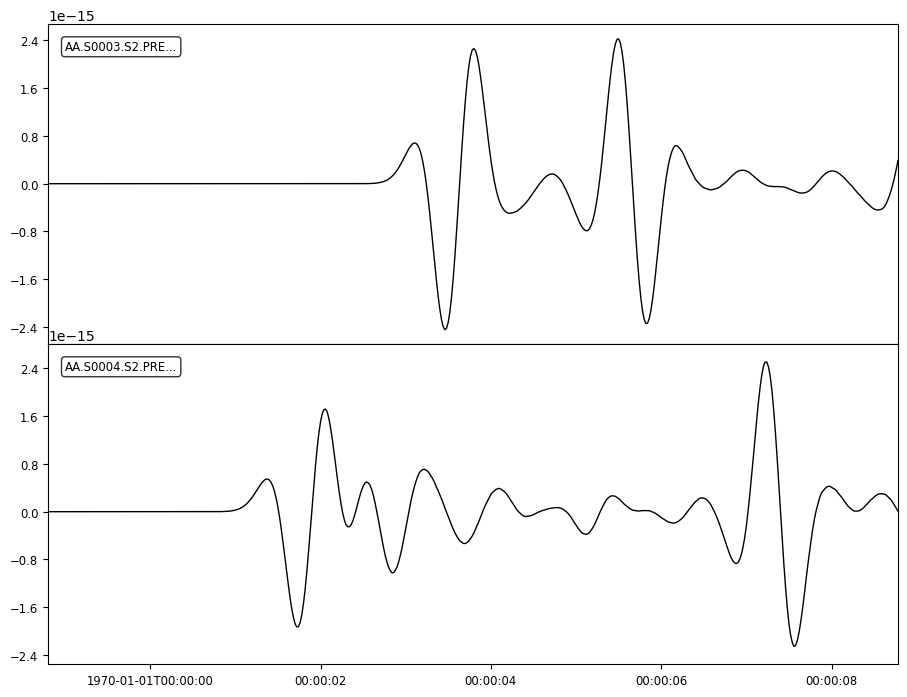

In [19]:
import glob
import os
import numpy as np
import obspy
import matplotlib.pyplot as plt

def get_traces(directory):
    traces = []
    files = glob.glob(directory + "/*.sem*")
    ## iterate over all seismograms
    for filename in files:
        station_name = os.path.splitext(filename)[0]
        station_name = station_name.split("/")[-1]
        trace = np.loadtxt(filename, delimiter=" ")
        starttime = trace[0, 0]
        dt = trace[1, 0] - trace[0, 0]
        traces.append(
            obspy.Trace(
                trace[:, 1],
                {"network": station_name, "starttime": starttime, "delta": dt},
            )
        )

    stream = obspy.Stream(traces)

    return stream


stream = get_traces("OUTPUT_FILES/results")
fig = plt.figure(figsize=(10, 8))
stream.plot(fig=fig)
plt.show()

### Visualize wavefield snapshots

We can also load the wavefield snapshots and plot them. The snapshots are
stored in the `OUTPUT_FILES/results` directory. We can use the `matplotlib`
library to plot them.

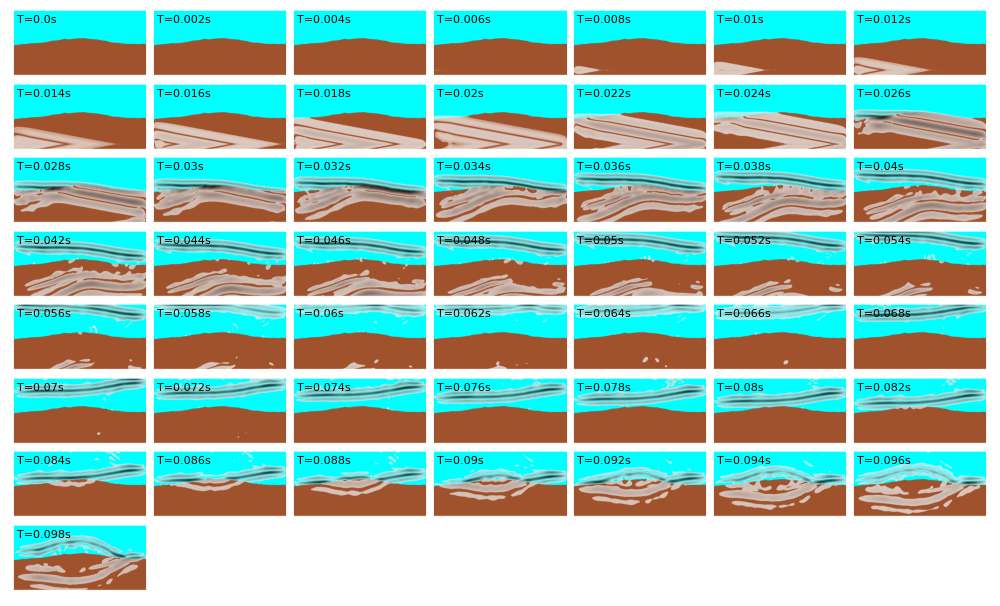

In [20]:

def plot_snapshots(directory):
    files = glob.glob(directory + "/*.png")
    files.sort()
    N = len(files)
    Nx = np.ceil(np.sqrt(N)).astype(int)
    Ny = np.ceil(N / Nx).astype(int)
    fig, ax = plt.subplots(Nx, Ny, figsize=(10, 6))
    ax = ax.flatten()
    for i in range(Nx*Ny):
        if i >= N:
            ax[i].axis("off")
        else:
          img = plt.imread(files[i])
          ax[i].imshow(img[700:1900,100:-100,:])
          ax[i].axis("off")
          ax[i].text(0.05, 0.925, f"T={np.round(i*dt,4)}s", fontsize=8, color="black",
                     transform=ax[i].transAxes, ha="left", va="top")
    plt.subplots_adjust(wspace=0.0, hspace=0.0, left=0.01, right=0.99, top=0.99, bottom=0.01)
    plt.show(block=False)
    
plot_snapshots("OUTPUT_FILES/results")